In [1]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib import gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import galsim
import cv2 as cv
from scipy.signal import convolve2d
import tensorflow as tf
import plot_utils

tf.enable_eager_execution()

%matplotlib inline
np.seterr(divide='ignore', invalid='ignore')

tf.version.VERSION

'1.15.0'

In [2]:
tf.executing_eagerly()

True

In [3]:
dat = np.load('Data/Cat-SFG-17-01-2020.npz')
dat.files

['nobj', 'listgal', 'flux1400sfg', 'sizesfg', 'randidx', 'e1', 'e2']

In [4]:
dat['listgal'].shape

(300, 96, 96)

In [5]:
img1 = np.abs(fits.open('Data/psf2asec-96.psf.fits')[0].data[0,0,:,:])

### Loading PSF & SFG

In [6]:
gal = cv.resize(dat['listgal'][0,:,:], (64,64))
psf = cv.resize(galsim.Image(img1, copy=True).array, (64,64))

gal_up = cv.resize(dat['listgal'][0,:,:], (64*4,64*4))                   # Upsampled to remove alising
psf_up = cv.resize(galsim.Image(img1, copy=True).array, (64*4,64*4))

psf /= np.sum(psf)             # PSF flux = 1
psf_up /= np.sum(psf_up)

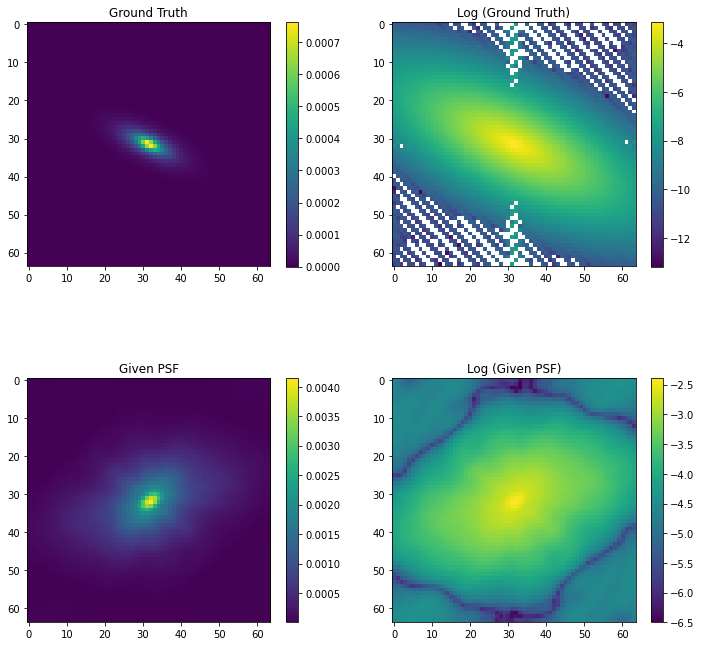

In [7]:
fig = plt.figure(figsize=(12,12))

plt.subplot(221)
plt.imshow(gal)
plt.colorbar(shrink=0.825)
plt.title('Ground Truth')

plt.subplot(222)
plt.imshow(np.log10(gal))
plt.colorbar(shrink=0.825)
plt.title('Log (Ground Truth)')

plt.subplot(223)
plt.imshow(psf)
plt.colorbar(shrink=0.825)
plt.title('Given PSF')

plt.subplot(224)
plt.imshow(np.log10(psf))
plt.colorbar(shrink=0.825)
plt.title('Log (Given PSF)')

plt.show()

### FFT(Ground Truth) + Gaussian Noise

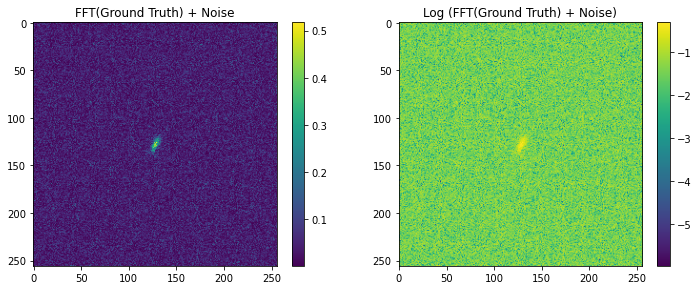

0.05687359927909602


In [8]:
gal_fft = np.fft.fftshift(np.fft.fft2(gal_up))   
psf_fft = np.fft.fftshift(np.fft.fft2(psf_up))      

# SNR(x) = l2_norm(x)/sigma_noise 

SNR = 50                                                          # Signal to noise ratio in Fourier domain
sigma_noise = np.linalg.norm(gal_fft)/SNR                         # Standard deviation of noise

gal_fft_GSO = galsim.Image(gal_fft, copy=True)                    # Stored as GSO
gal_fft_GSO.addNoise(galsim.GaussianNoise(sigma = sigma_noise)) 


fig = plt.figure(figsize=(12,12))

plt.subplot(121)
plt.imshow(np.abs(gal_fft_GSO.array))
plt.colorbar(shrink=0.375)
plt.title('FFT(Ground Truth) + Noise')

plt.subplot(122)
plt.imshow(np.log10(np.abs(gal_fft_GSO.array)))
plt.colorbar(shrink=0.375)
plt.title('Log (FFT(Ground Truth) + Noise)')

plt.show()

print(sigma_noise)

### Convolve with PSF

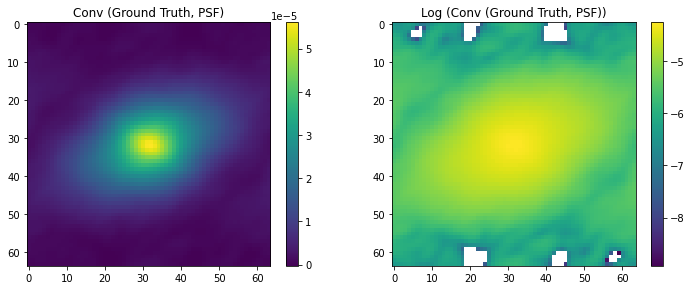

(0.030397305292520813, 0.030397305292520813)

In [9]:
conv = gal_fft_GSO.array * psf_fft

final_gal = np.real(np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(conv))))     # IFFT to get back to brightness domain
final_gal = cv.resize(final_gal, (64,64))    
final_gal *= (np.sum(gal)/np.sum(final_gal))                                   # Normalisation


fig = plt.figure(figsize=(12,12))

plt.subplot(121)
plt.imshow(final_gal)
plt.colorbar(shrink=0.375)
plt.title('Conv (Ground Truth, PSF)')

plt.subplot(122)
plt.imshow(np.log10(final_gal))
plt.colorbar(shrink=0.375)
plt.title('Log (Conv (Ground Truth, PSF))')

plt.show()

np.sum(final_gal), np.sum(gal)

# ADMM in TensorFlow

In [10]:
def ADMM_tf(gal, final_gal, psf, n_iter, disp_step):
    
    
    # Convert arrays to tensors

    gal_tf = tf.cast(gal, tf.float32)
    final_gal_tf = tf.cast(final_gal, tf.float32)
    psf_tf = tf.cast(psf, tf.float32)
    
    
    
    # Utility Functions

    def fftconvolve(image, kernel):

        x = tf.signal.fftshift(tf.signal.fft2d(tf.cast(image, tf.complex64)))
        y = tf.signal.fftshift(tf.signal.fft2d(tf.cast(kernel, tf.complex64)))
        result = tf.math.real(tf.signal.fftshift(tf.signal.ifft2d(tf.signal.ifftshift(x * y))))

        return tf.cast(result, tf.float32)


    def fft(data):

        return tf.math.real( tf.convert_to_tensor(1.0/data.get_shape().as_list()[0], tf.complex64) * 
                             tf.signal.fftshift(tf.signal.fft2d(tf.signal.ifftshift(tf.cast(data, tf.complex64)))) )


    def ifft(data):

        return tf.math.real( tf.convert_to_tensor(data.get_shape().as_list()[0], tf.complex64) *
                             tf.signal.fftshift(tf.signal.ifft2d(tf.signal.ifftshift(tf.cast(data, tf.complex64)))) )


    def nmse(signal_1, signal_2):

        return tf.keras.backend.get_value(tf.norm(signal_2 - signal_1)**2 / tf.norm(signal_1)**2)


    def max_sv(psf, sigma, rho):

        H = tf.signal.fft2d(tf.cast(psf, tf.complex64))
        normH = tf.math.abs(tf.reverse(tf.reverse(H, axis=[0]), axis=[1]) * H  +  tf.cast(rho*sigma**2, tf.complex64))
        return tf.cast(tf.math.reduce_max(normH), tf.float32)     
    
    
    # Projection - Enforce non-negative values
    def proj(xi):

        return tf.cast(tf.math.maximum(xi, 0.0), tf.float32)


    # H operator
    def H(data, psf):

        return fftconvolve(data, psf)


    # H transpose operator
    def Ht(data, psf):

        return fftconvolve(data, tf.reverse(tf.reverse(psf, axis=[0]), axis=[1]))      # rotate by 180


    # The gradient
    def grad(y, x_rec, psf):

        return Ht(H(x_rec, psf) - y, psf)


    # The cost function
    def cost_func(y, x_rec, z, mu, rho, psf, var):

        temp = z - x_rec
        shape = mu.get_shape().as_list()

        cost_val = ( tf.cast(0.5, tf.float32) * rho * tf.norm(temp)**2  -
                     tf.matmul(tf.reshape(mu, [1, shape[0]*shape[1]]), tf.reshape(temp, [shape[0]*shape[1], 1]))  +
                     (tf.cast(0.5, tf.float32) / var) * tf.norm(y - H(x_rec, psf))**2 )

        return tf.keras.backend.eval(cost_val).flatten()


    # Compute gradient step size   
    def get_alpha(rho, sv, sigma):

        return (tf.cast(1.0, tf.float32) / 
                ((sv/(sigma**2) + rho) * tf.cast(1.0 + 1.0e-5, tf.float32)))



    # Run ADMM
    def runADMM(y, x_0, psf, grad, z_0, mu_0, rho_0, rho_max, eta, gamma, disp_step, n_iter):


        # Convert arrays to tensors

        x_0 = tf.cast(x_0, tf.float32)
        z_0 = tf.cast(z_0, tf.float32)
        mu_0 = tf.cast(mu_0, tf.float32)
        rho_0 = tf.cast(rho_0, tf.float32)          # Augmented lagrangian hyperparameter
        rho_max = tf.cast(rho_max, tf.float32)      # max rho value
        eta = tf.cast(eta, tf.float32)              # should be between - [0, 1)
        gamma = tf.cast(gamma, tf.float32)          # multiplicative rho factor -- Should be > 1


        # declare variables

        cost = []
        nmse_arr = np.full(n_iter, np.inf)
        x_opt = tf.zeros(tf.shape(y.shape), tf.float32)
        count = 0


        # ADMM parameters

        x_k = x_0
        z_k = z_0
        mu_k = mu_0
        rho_k = rho_0                                  # Augmented lagrangian hyperparameter
        delta_k = tf.cast(0.0, tf.float32)      


        # FISTA parameters

        t_k = tf.cast(1.0, tf.float32)
        z_fista_old = z_0
        sigma = tf.cast(sigma_noise, tf.float32) / 4000.0


        # square of spectral radius of convolution matrix

        sv = max_sv(psf, sigma, rho_k)         


        # The gradient descent step

        alpha = get_alpha(rho_k, sv, sigma) 


        # ADMM Loop 

        for k in range(n_iter):


            ## FISTA update

            x_k1 = z_fista_old - alpha * (grad(y, z_fista_old, psf)  + 
                                          mu_k * sigma**2  + 
                                          rho_k * sigma**2 * (z_fista_old - z_k)) 

            x_k1 = proj(x_k1)             # Project negative values

            t_k1 = ( (tf.cast(1.0, tf.float32) + tf.math.sqrt(tf.cast(4.0, tf.float32)*t_k**2 + tf.cast(1.0, tf.float32))) 
                    / tf.cast(2.0, tf.float32) )

            lambda_fista = tf.cast(1.0, tf.float32) + (t_k -  tf.cast(1.0, tf.float32)) / t_k1

            z_fista_new = x_k + lambda_fista * (x_k1 - x_k)

            z_fista_old = z_fista_new
            t_k = t_k1



            ## Denoising sub-step

            z_k1 = x_k1 + (mu_k / rho_k)



            ## mu update

            mu_k1 = mu_k + (x_k1 - z_k1) * rho_k



            ## Cost

            cost.append(cost_func(y, x_k1, z_k1, mu_k1, rho_k, psf, var=sigma**2))



            ## Rho & alpha update       

            test1 = (tf.math.abs(gamma * rho_k) < tf.math.abs(rho_max))

            delta_k1 = tf.cond(test1, lambda: (tf.cast(1.0/gal_tf.get_shape().as_list()[0], tf.float32) * 
                                               (tf.norm(x_k1 - x_k) + tf.norm(z_k1 - z_k) + tf.norm(mu_k1 - mu_k))), 
                                      lambda: delta_k)

            test2 = (test1 and (tf.math.abs(delta_k1) > tf.math.abs(eta * delta_k)))

            rho_k1 = tf.cond(test2, lambda: gamma * rho_k, lambda: rho_k)
            alpha = tf.cond(test2, lambda: get_alpha(rho_k1, sv, 1.0), lambda: alpha)




            # Update all variables

            delta_k = tf.cond(test1, lambda: delta_k1, lambda: delta_k)
            rho_k = rho_k1
            x_k = x_k1
            mu_k = mu_k1
            z_k = z_k1
            sv = max_sv(psf, sigma, rho_k)


            # Reconstruction

            final_im = x_k


            # Compute NMSE

            nmse_arr[k] = nmse(gal_tf, final_im)


            # Check if optimal reconstruction is achieved

            if nmse_arr[k]==np.min(nmse_arr):
                x_opt = final_im


            # Display plots

            if (k+1)%disp_step==0 and k!=0:
                plot_utils.plot_iter(final_im, gal, y, k+1)


        return x_opt, cost, nmse_arr


    
    # ADMM parameters (initial)
    x_0 = np.zeros(gal.shape)
    z_0 = np.zeros(gal.shape)
    mu_0 = 0.0                              
    rho_0 = 50.0                         # Augmented lagrangian hyperparameter
    rho_max = 200.0                      # max rho value
    eta = 0.5                            # should be between - [0, 1)
    gamma = 1.4                          # multiplicative rho factor -- Should be > 1


    # Deconvolve the image
    x_opt, cost, nmse_arr = runADMM(final_gal_tf, x_0, psf_tf, grad, z_0, mu_0, rho_0, 
                                    rho_max, eta, gamma, disp_step, n_iter)

    
    # Comparison
    plot_utils.comparison_fft(x_opt, gal_tf, final_gal_tf, psf_tf, fftconvolve, fft)
    
    # Plot NMSE
    plot_utils.nmse(nmse_arr, n_iter)
    
    # Plot Cost
    plot_utils.cost(cost, n_iter)
    
    
    return x_opt, nmse_arr

# ADMM in NumPy

In [11]:
def ADMM_np(gal, final_gal, psf, n_iter, disp_step):
    
    
    # Utility Functions

    def fftconvolve(image, kernel):

        x = np.fft.fftshift(np.fft.fftn(image))
        y = np.fft.fftshift(np.fft.fftn(kernel))

        return np.real(np.fft.fftshift(np.fft.ifftn(np.fft.ifftshift(x * y))))


    def fft(data):

        return (1 / np.sqrt(data.size) *
                np.fft.fftshift(np.fft.fftn(np.fft.ifftshift(data))))


    def ifft(data):

        return (np.sqrt(data.size) *
                np.fft.fftshift(np.fft.ifftn(np.fft.ifftshift(data))))


    def nmse(signal_1, singal_2):

        return (np.linalg.norm(singal_2 - signal_1) ** 2 /
                np.linalg.norm(signal_1) ** 2)


    def max_sv(psf, sigma, rho):

        H = np.fft.fft2(psf)
        normH = np.abs(np.rot90(H, 2)*H + rho*sigma**2)
        return np.real(np.max(normH))    
    
    
    
    # Projection - Enforce non-negative values
    def proj(xi):

        return np.real(np.maximum(xi,0))


    # H operator
    def H(data, psf):

        return fftconvolve(data, psf)


    # H transpose operator
    def Ht(data, psf):

        return fftconvolve(data, np.rot90(psf, 2))


    # The gradient
    def grad(y, x_rec, psf):

        return Ht(H(x_rec, psf) - y, psf)


    # The cost function
    def cost_func(y, x_rec, z, mu, rho, psf, var):

        cost_val = (0.5 * rho * np.linalg.norm(z - x_rec)**2 - 
                    np.dot(mu.flatten(),(z - x_rec).flatten()) + 
                    (0.5/var) * np.linalg.norm(y - H(x_rec, psf))**2)

        return np.real(cost_val)


    # gradient step size update
    def get_alpha(rho, sv, sigma):

        return (1.0 / ((sv/(sigma**2) + rho)*(1.0 + 1.0e-5)))



    # Run ADMM
    def runADMM(y, x_0, psf, grad, z_0, mu_0, rho_0, rho_max, eta, gamma, disp_step, n_iter):

        cost = []
        nmse_arr = np.full(n_iter, np.inf)
        x_opt = np.zeros(y.shape)
        count = 0

        # ADMM parameters
        x_k = x_0
        z_k = z_0
        mu_k = mu_0
        rho_k = rho_0                                  # Augmented lagrangian hyperparameter
        delta_k = 0.0      

        # FISTA parameters
        t_k = 1.0
        z_fista_old = z_0
        sigma = sigma_noise


        # square of spectral radius of convolution matrix
        sv = max_sv(psf, sigma, rho_k)         


        # The gradient descent step
        alpha = get_alpha(rho_k, sv, sigma)


        for k in range(n_iter):


            ## FISTA update

            x_k1 = z_fista_old - alpha * (grad(y, z_fista_old, psf) + 
                                          mu_k * sigma**2 + 
                                          rho_k * sigma**2 * (z_fista_old - z_k))

            x_k1 = proj(x_k1)

            t_k1 = (1. + np.sqrt(4. * t_k**2 + 1.))/2.
            lambda_fista = 1 + (t_k - 1)/t_k1
            z_fista_new = x_k + lambda_fista * (x_k1 - x_k)

            z_fista_old = z_fista_new
            t_k = t_k1


            ## Denoising
            z_k1 = x_k1 + (mu_k/rho_k)


            ## mu update
            mu_k1 = mu_k + (x_k1 - z_k1) * rho_k


            ## Cost
            cost.append(cost_func(y, x_k1, z_k1, mu_k1, rho_k, psf, var=sigma**2))


            ## Rho & alpha update

            if (gamma * rho_k < rho_max):

                delta_k1 = (1./y.shape[0])*(np.linalg.norm(x_k1 - x_k) + 
                                            np.linalg.norm(z_k1 - z_k) + 
                                            np.linalg.norm(mu_k1 - mu_k))

                if (delta_k1 > eta * delta_k):

                    rho_k1 = gamma * rho_k
                    alpha = get_alpha(rho_k1, sv, sigma)

                delta_k = delta_k1



            # Update all variables
            x_k = x_k1
            mu_k = mu_k1
            z_k = z_k1
            rho_k = rho_k1
            sv = max_sv(psf, sigma, rho_k)


            # Convert back to signal domain
            final_im = x_k


            # Compute NMSE
            nmse_arr[k] = nmse(gal, final_im)


            # Check if optimal reconstruction is achieved
            if nmse_arr[k]==np.min(nmse_arr):
                x_opt = final_im


            if (k+1)%disp_step==0 and k!=0:
                plot_utils.plot_iter_np(final_im, gal, y, k)

        return x_opt, nmse_arr, cost    


    # ADMM parameters (initial)
    x_0 = np.zeros(final_gal.shape)
    z_0 = np.zeros(final_gal.shape)
    mu_0 = 0.0
    rho_0 = 50.0          # Augmented lagrangian hyperparameter
    rho_max = 200.0       # max rho value
    eta = 0.5             # should be between - [0, 1)
    gamma = 1.4           # multiplicative rho factor -- Should be > 1


    # Deconvolve the image
    x_opt, nmse_arr, cost = runADMM(final_gal, x_0, psf, grad, z_0, mu_0, rho_0, rho_max, 
                                    eta, gamma, disp_step, n_iter=n_iter)
    
    # Comparison
    plot_utils.comparison_np(x_opt, gal, final_gal, psf, fftconvolve, fft)
    
    # Plot NMSE
    plot_utils.nmse(nmse_arr, n_iter)

    # Plot Cost
    plot_utils.cost(cost, n_iter)
    
    return x_opt, nmse_arr

In [12]:
n_iter = 10000
disp_step = 1000

### NumPy Results

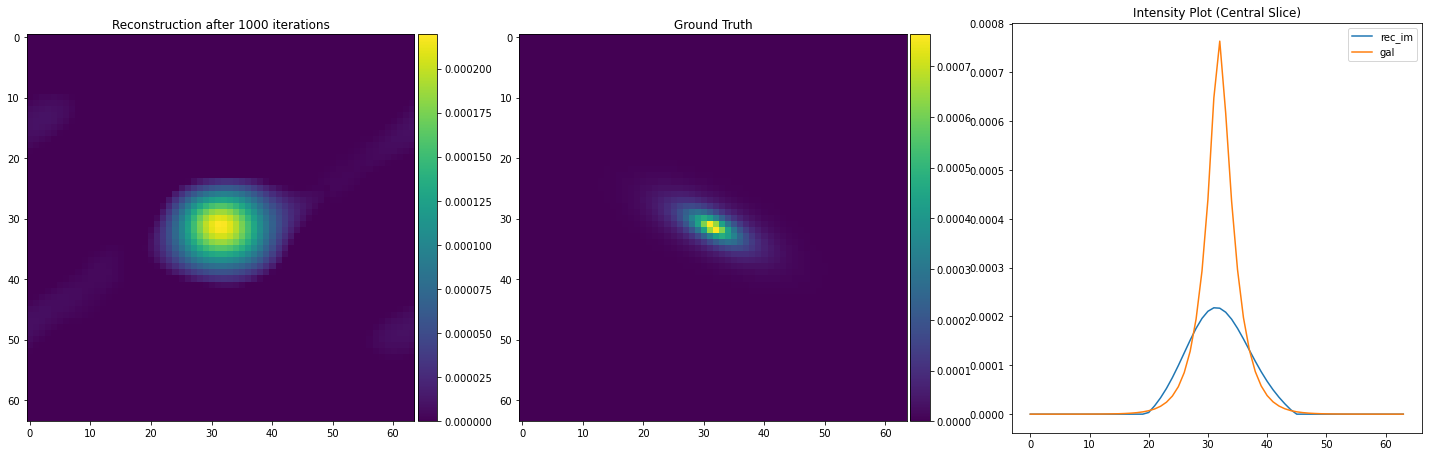

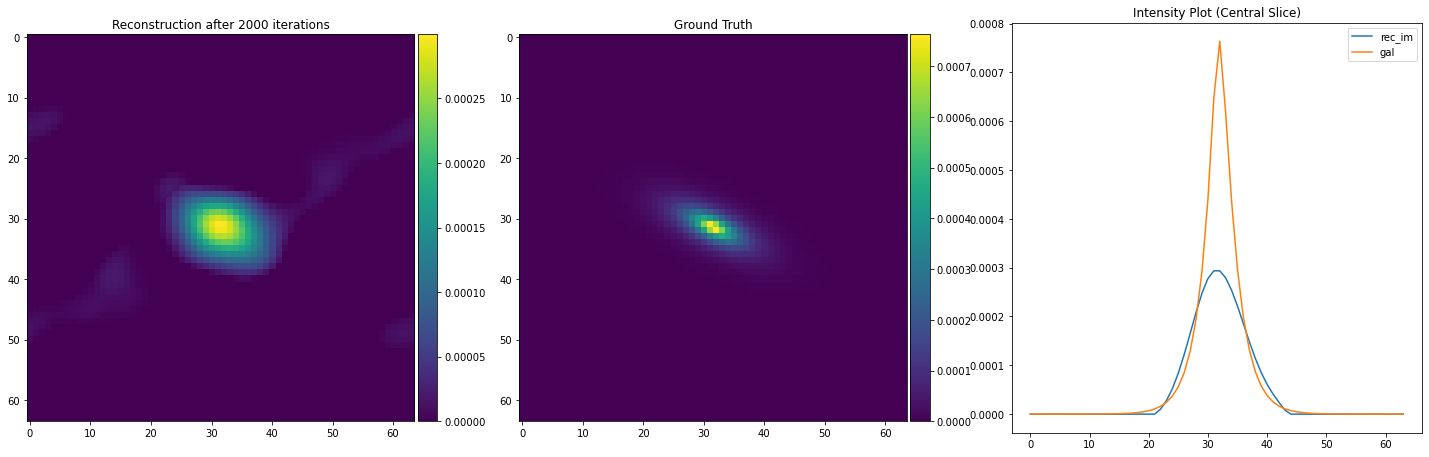

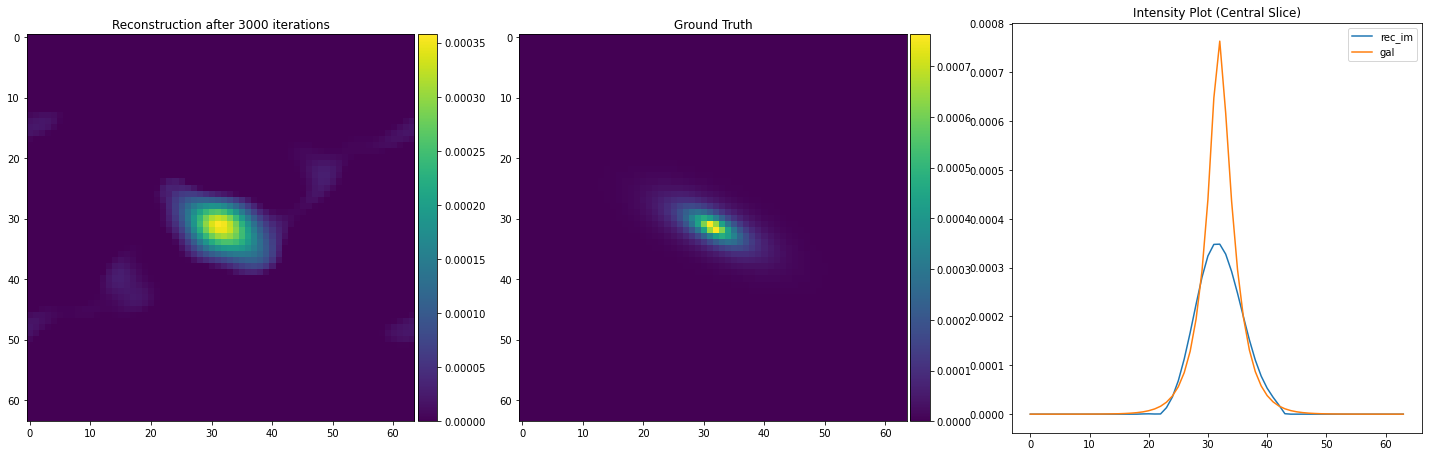

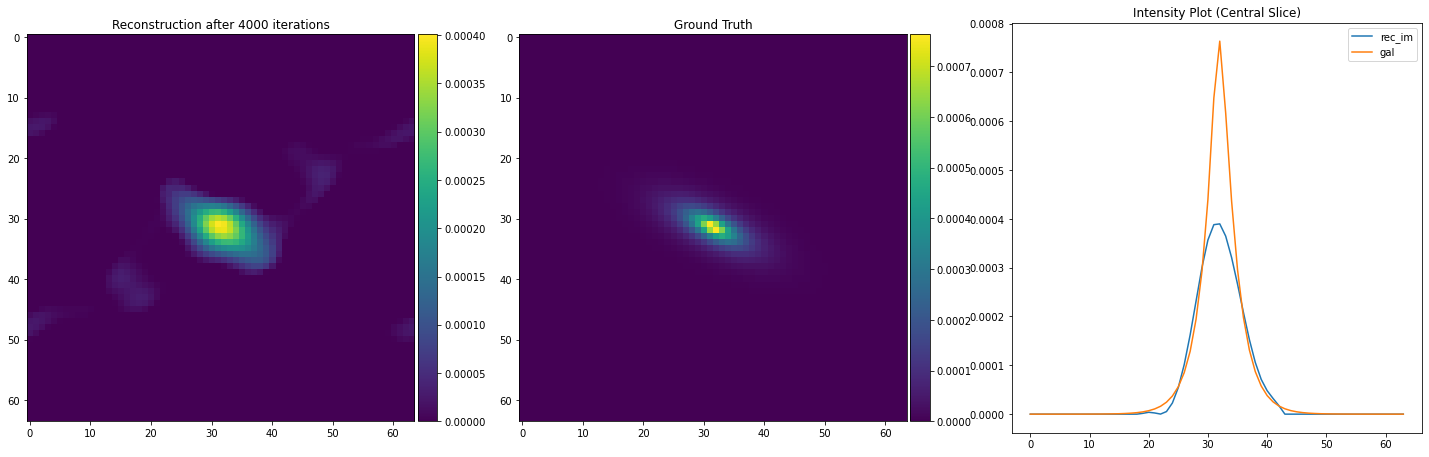

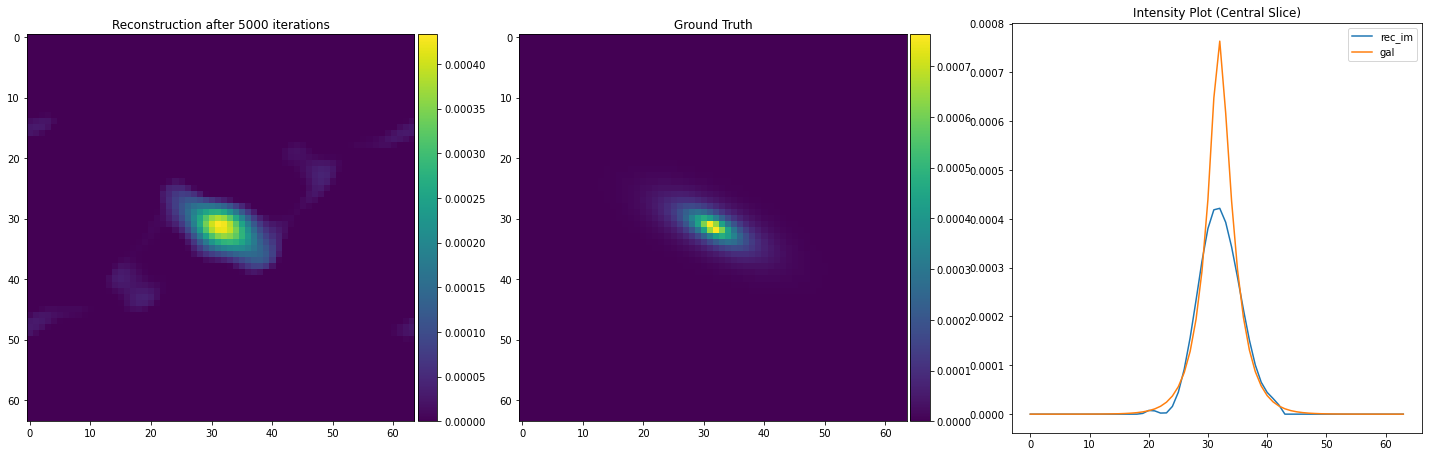

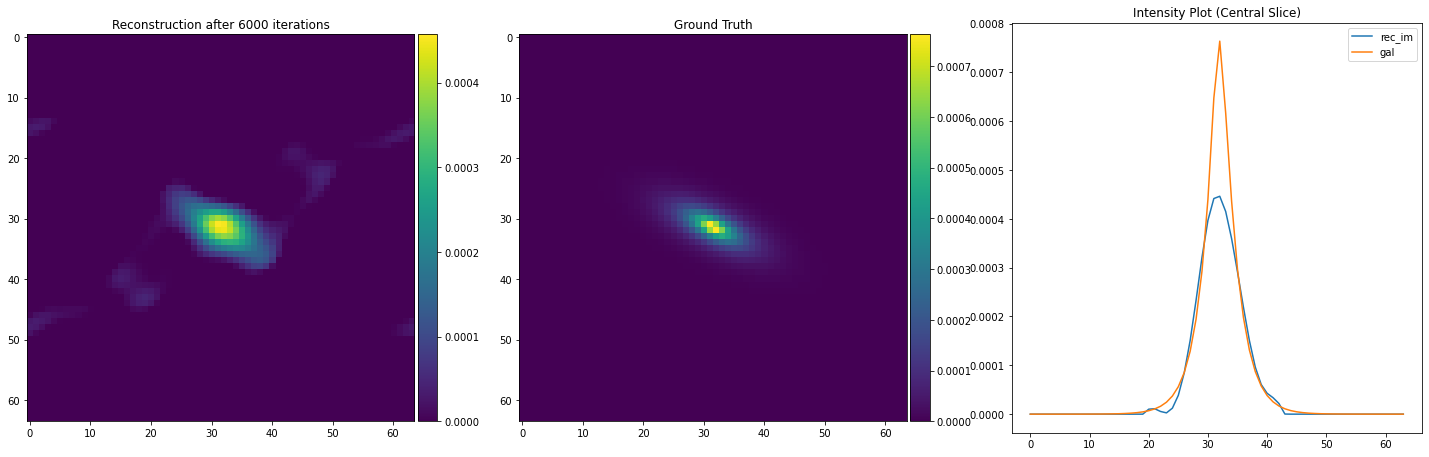

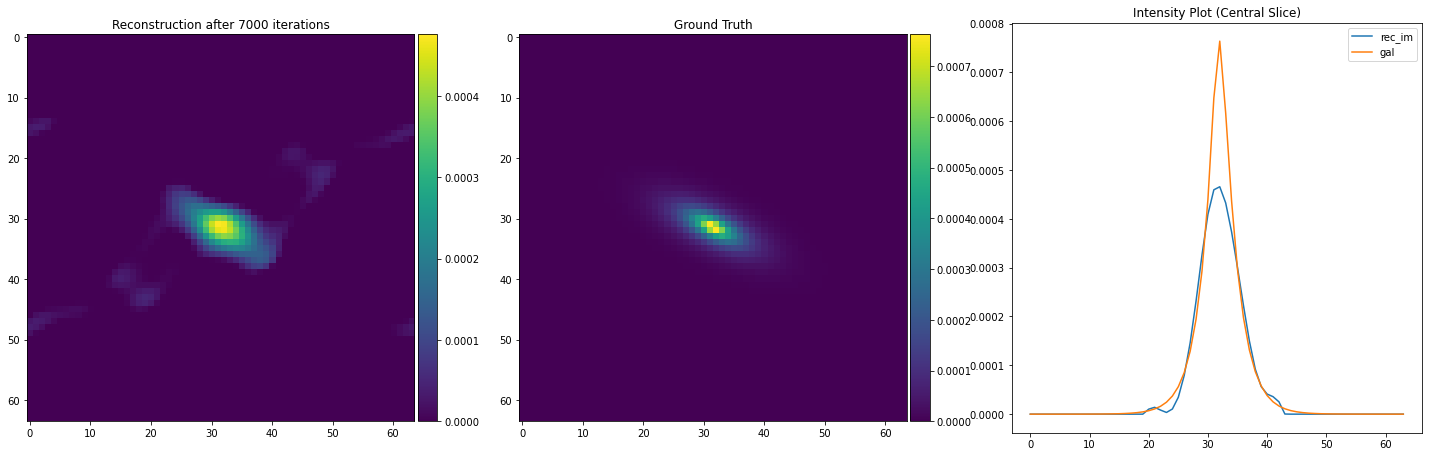

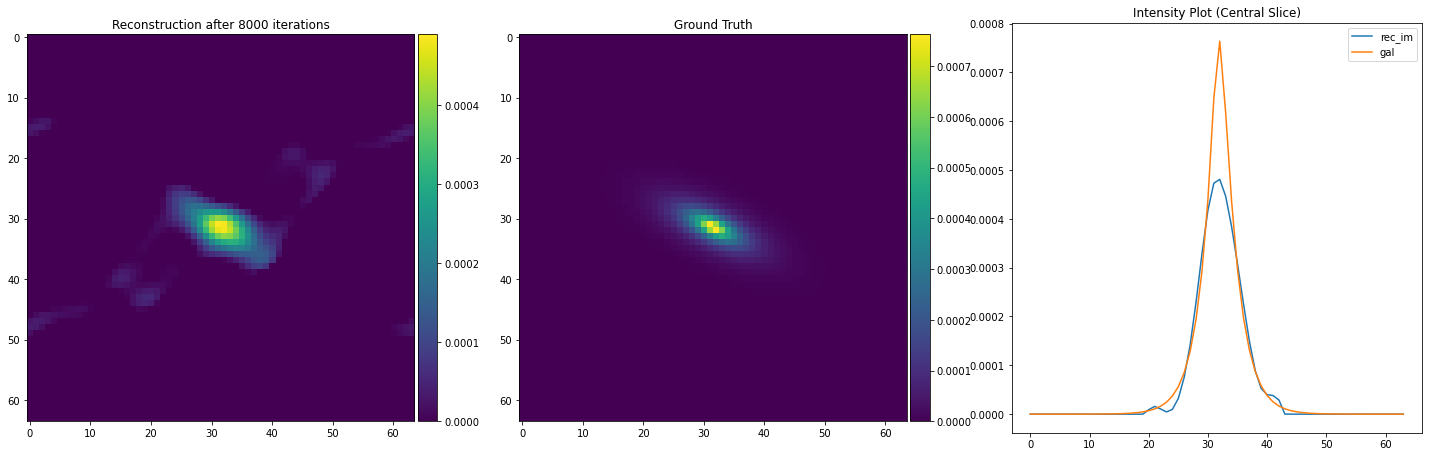

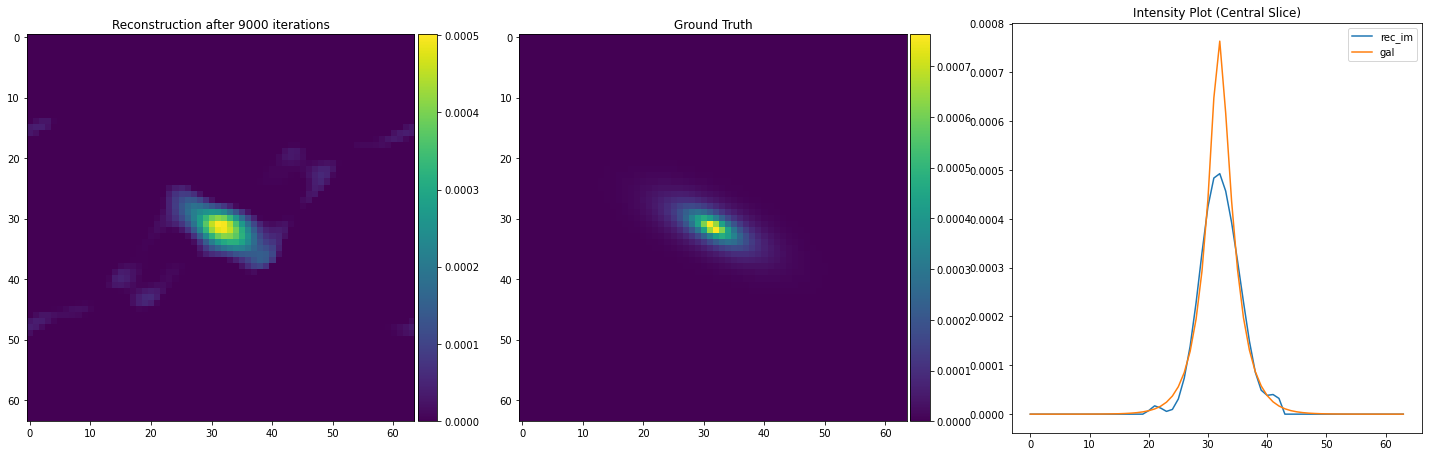

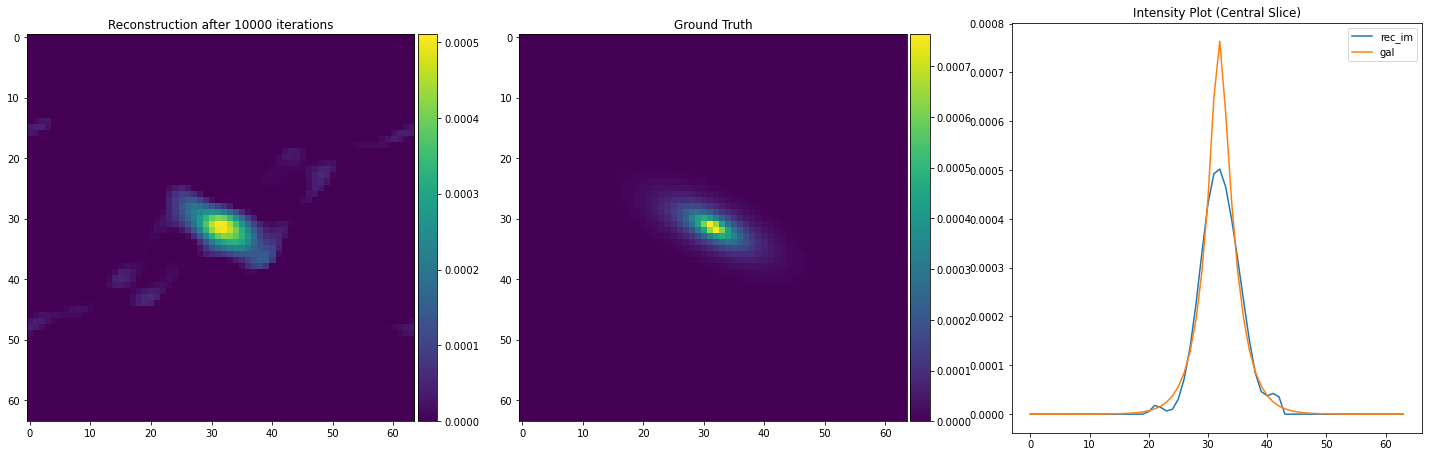

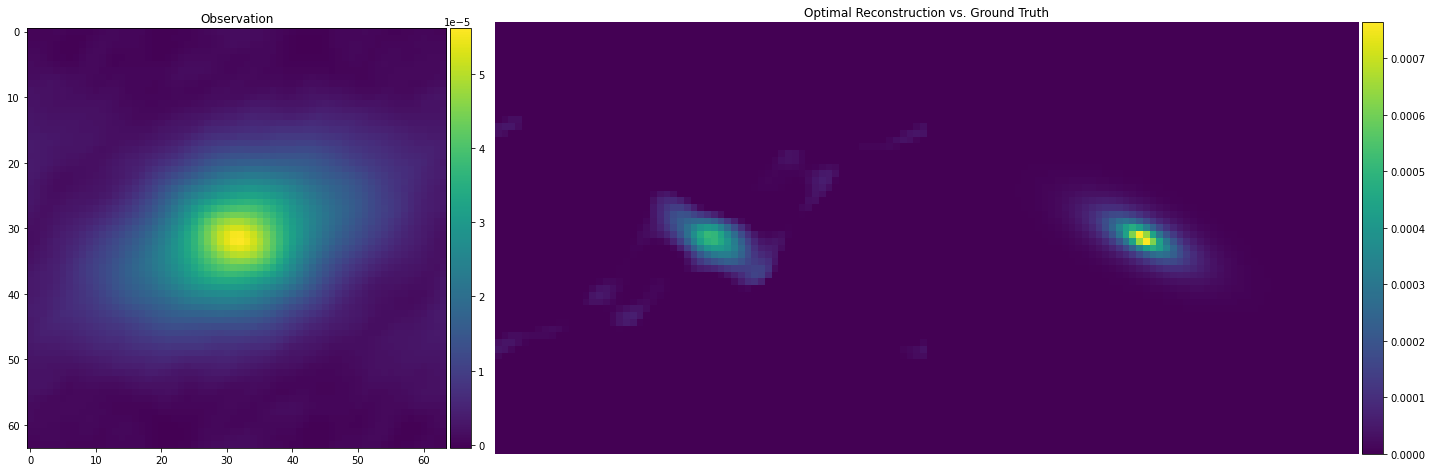

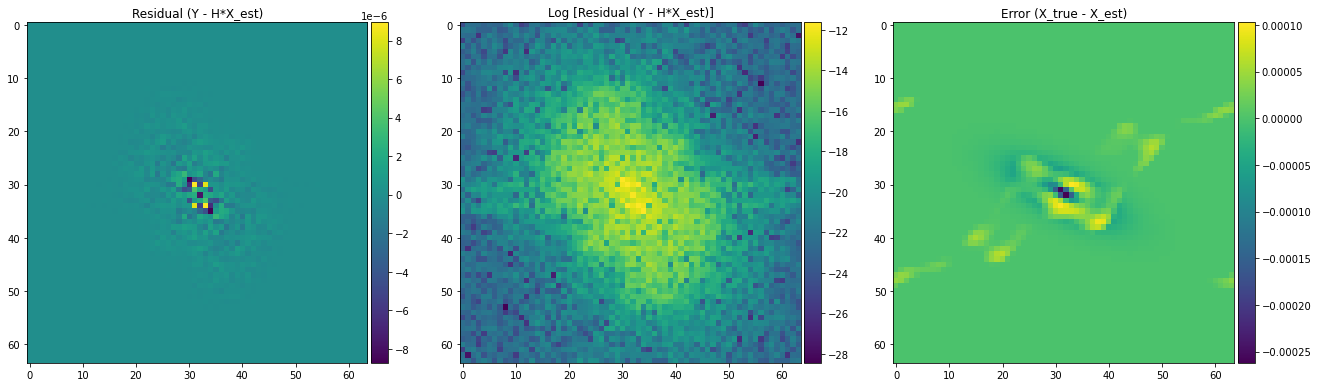

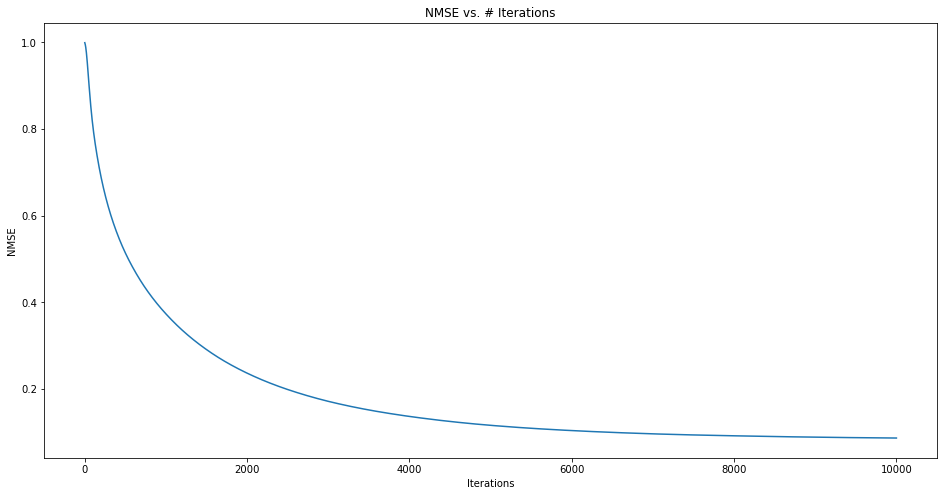


Minimum NMSE = 0.0870745112881683 (at [10000] iterations)


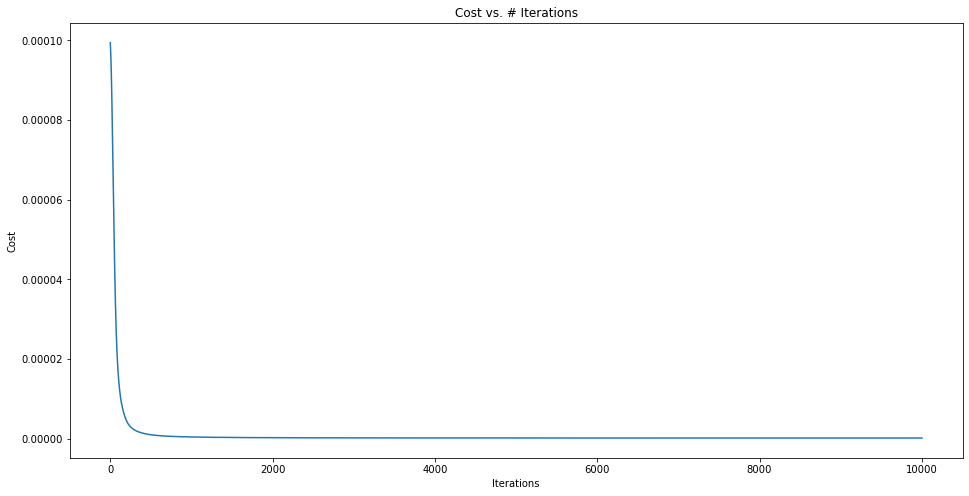


Minimum Cost = 1.7552503448468596e-07 (at [10000] iterations)


In [13]:
rec_np, nmse_np = ADMM_np(gal, final_gal, psf, n_iter, disp_step)

### TensorFlow Results

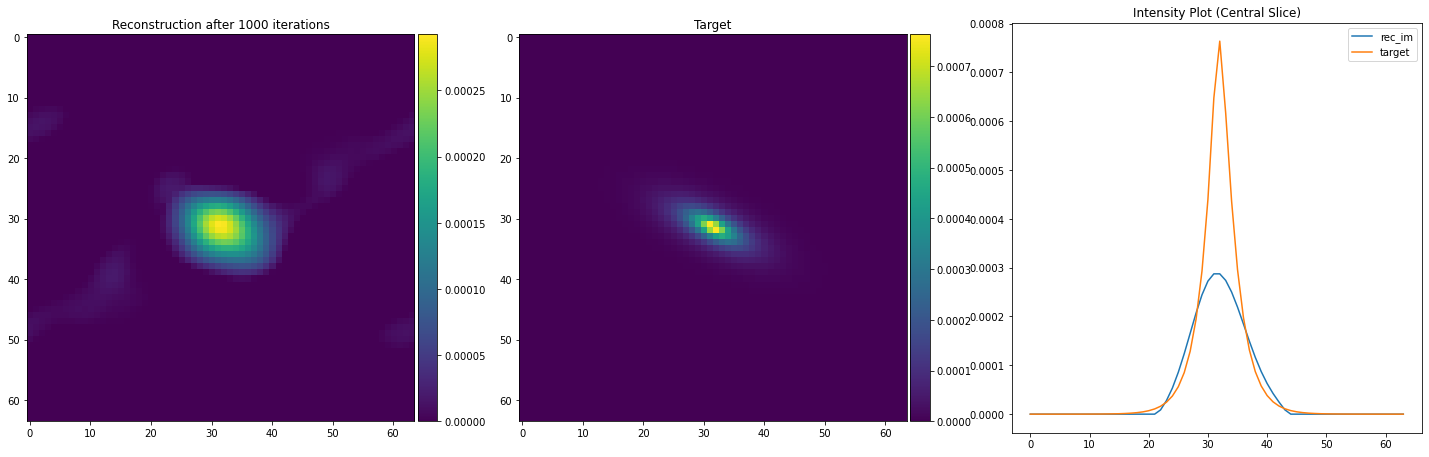

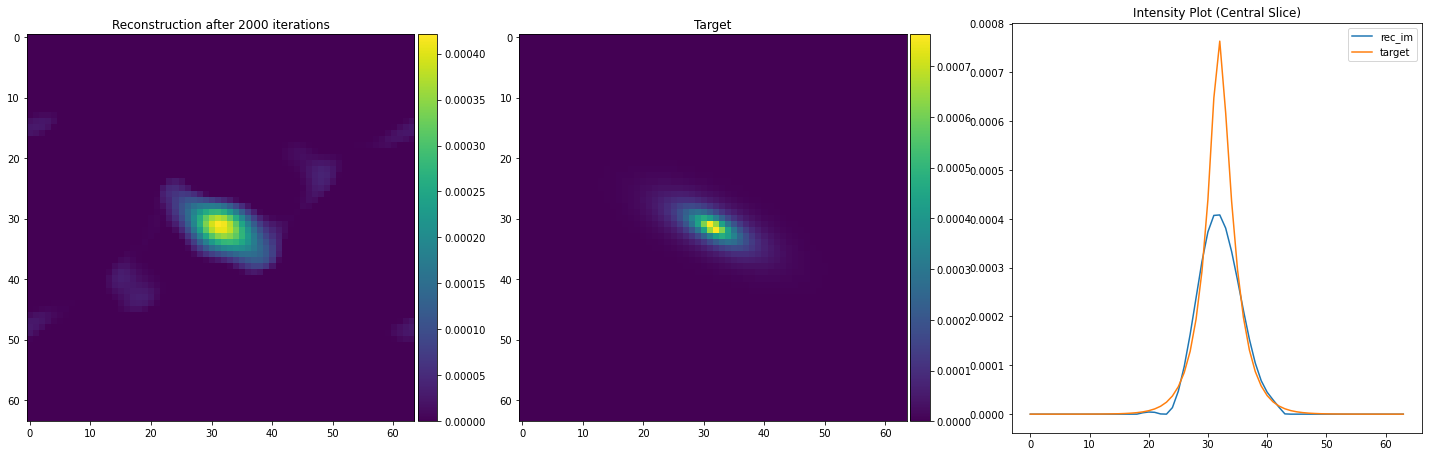

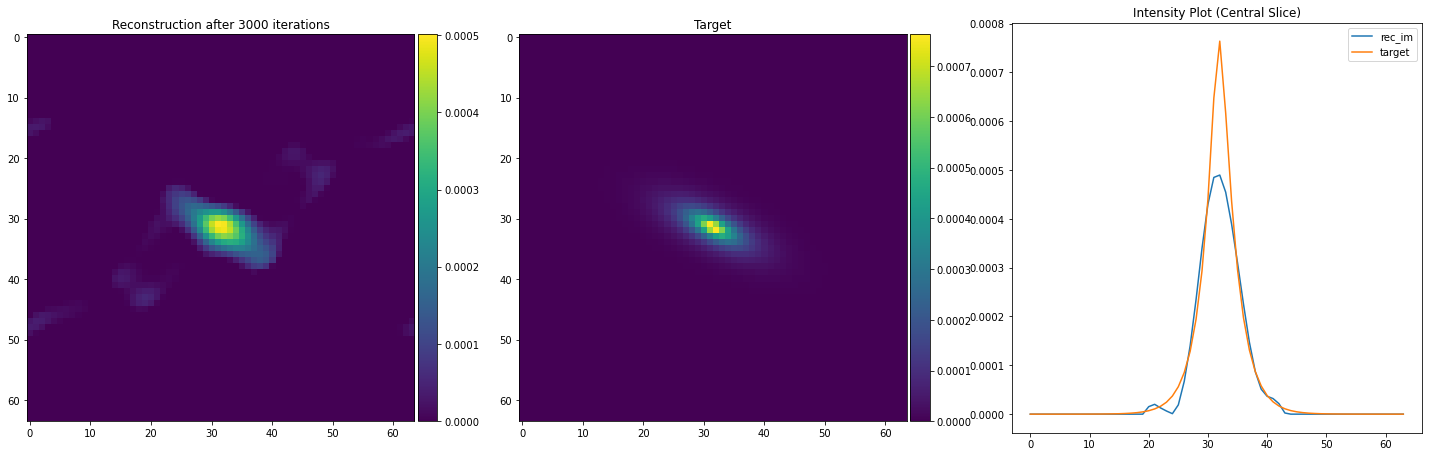

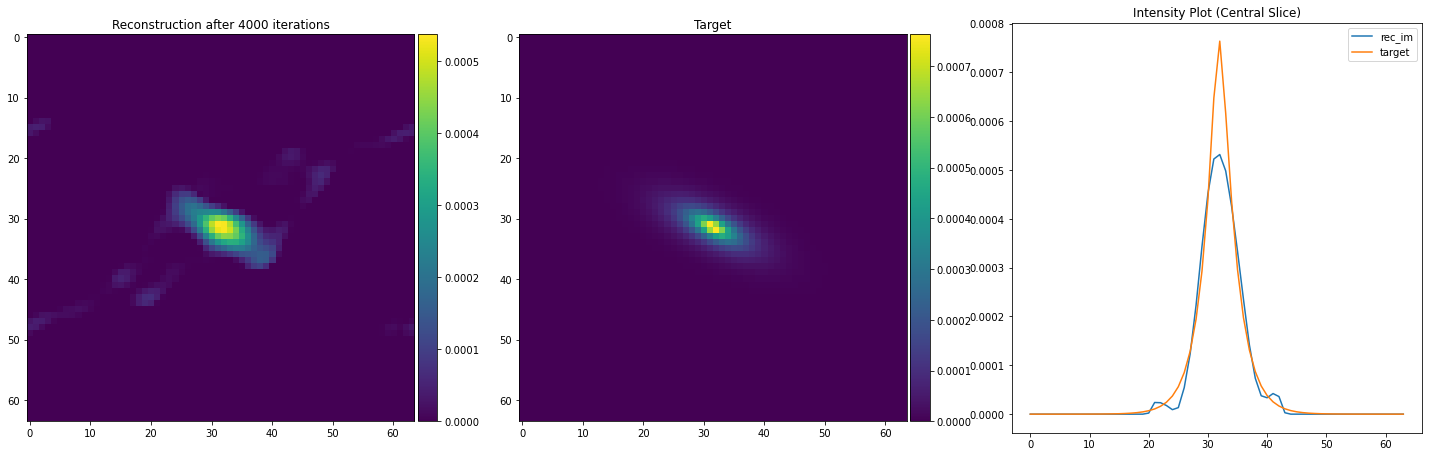

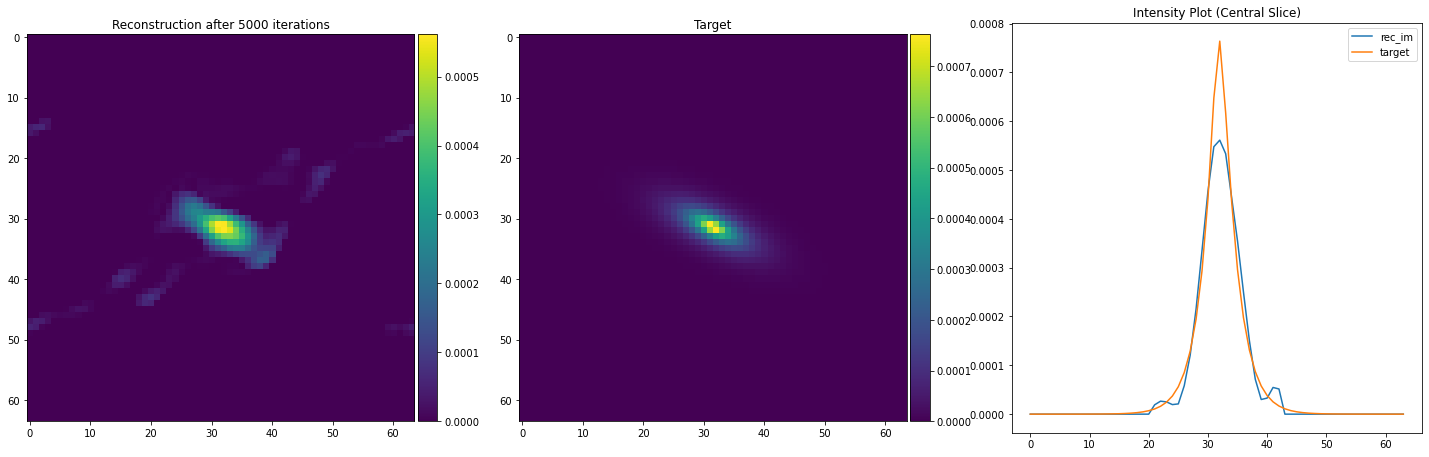

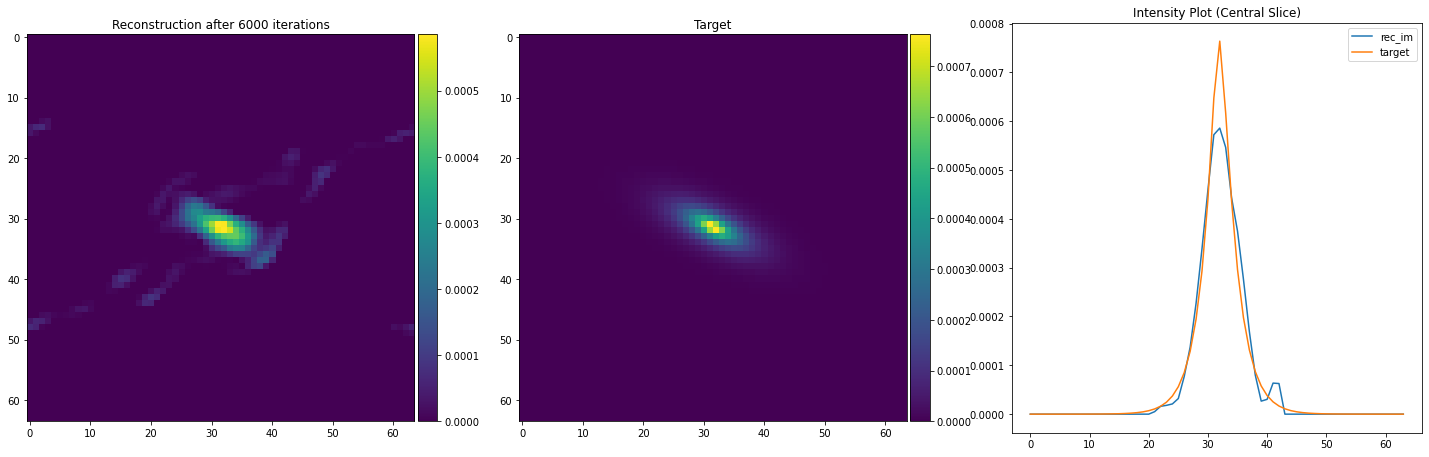

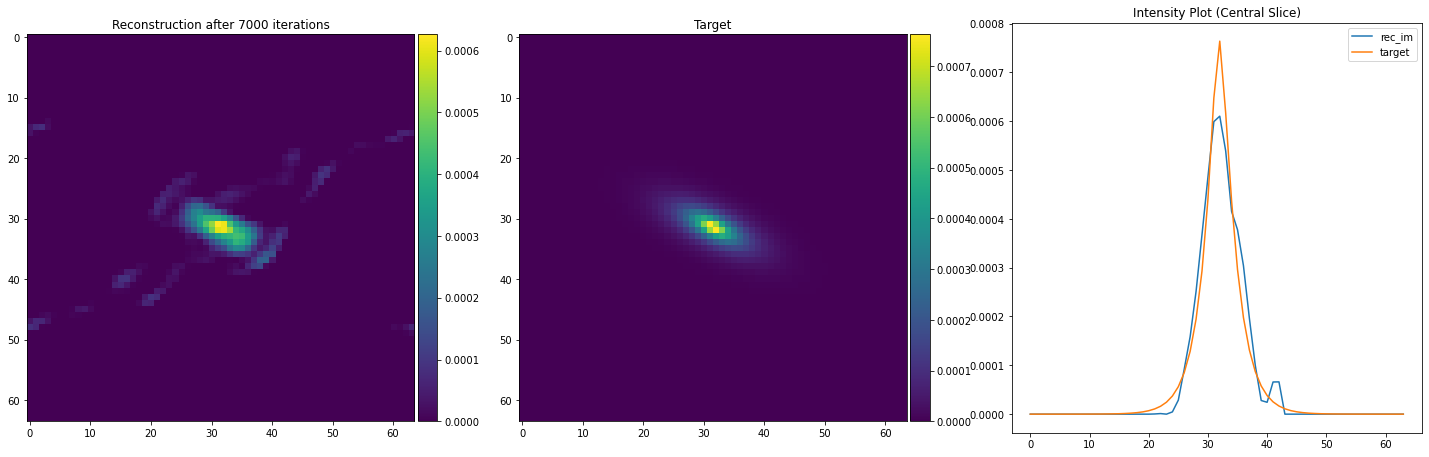

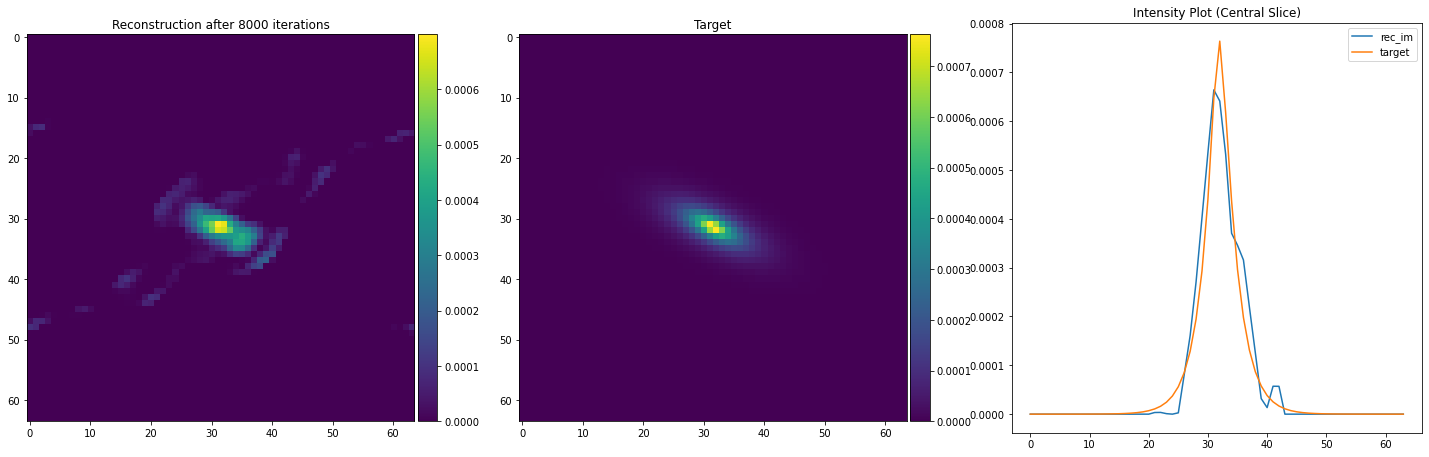

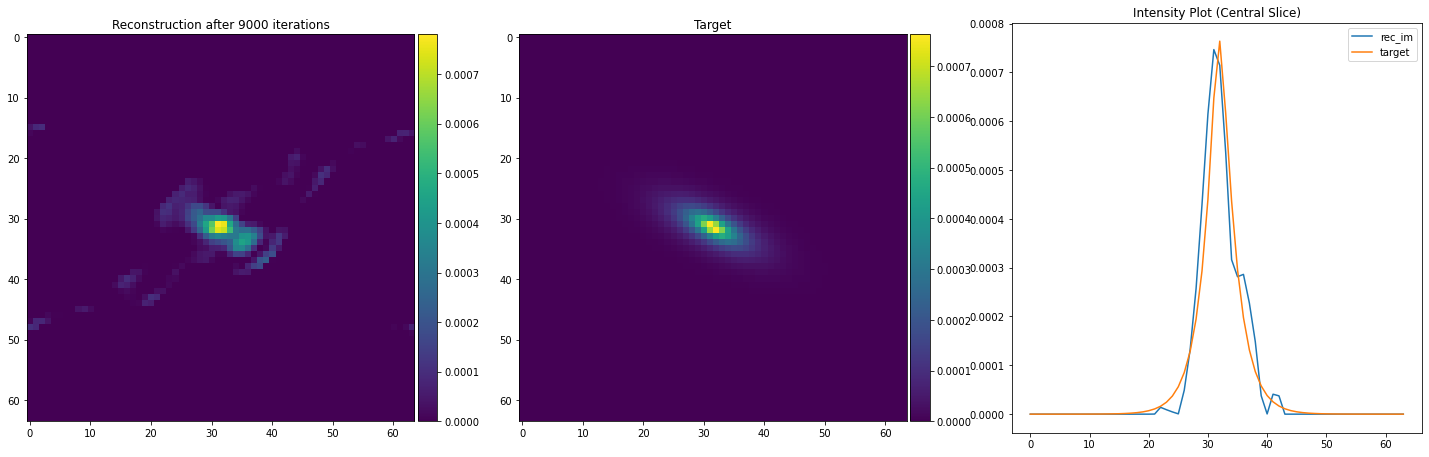

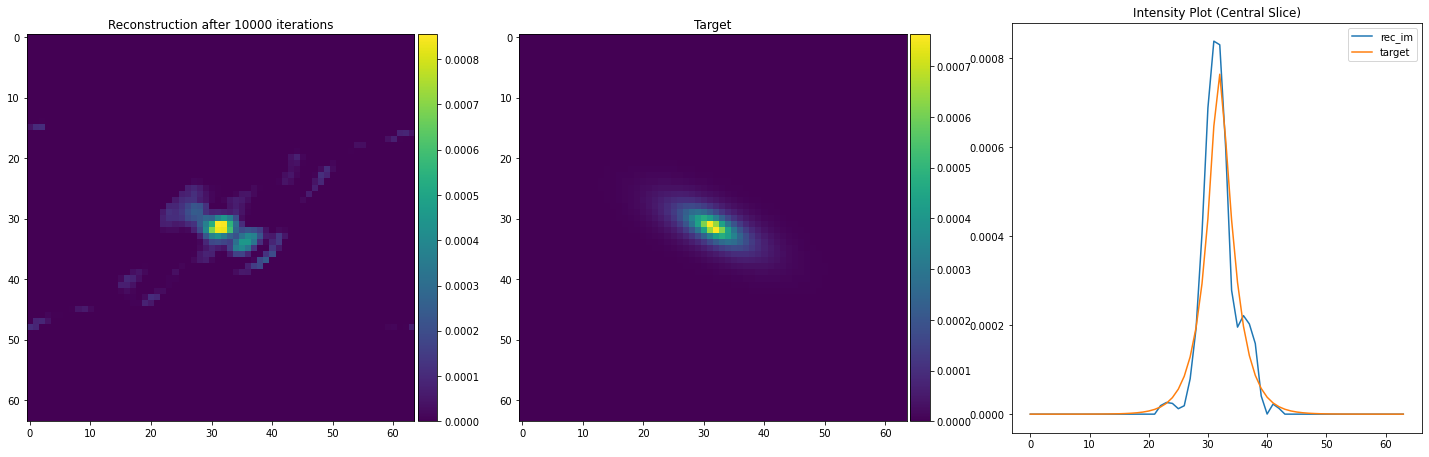

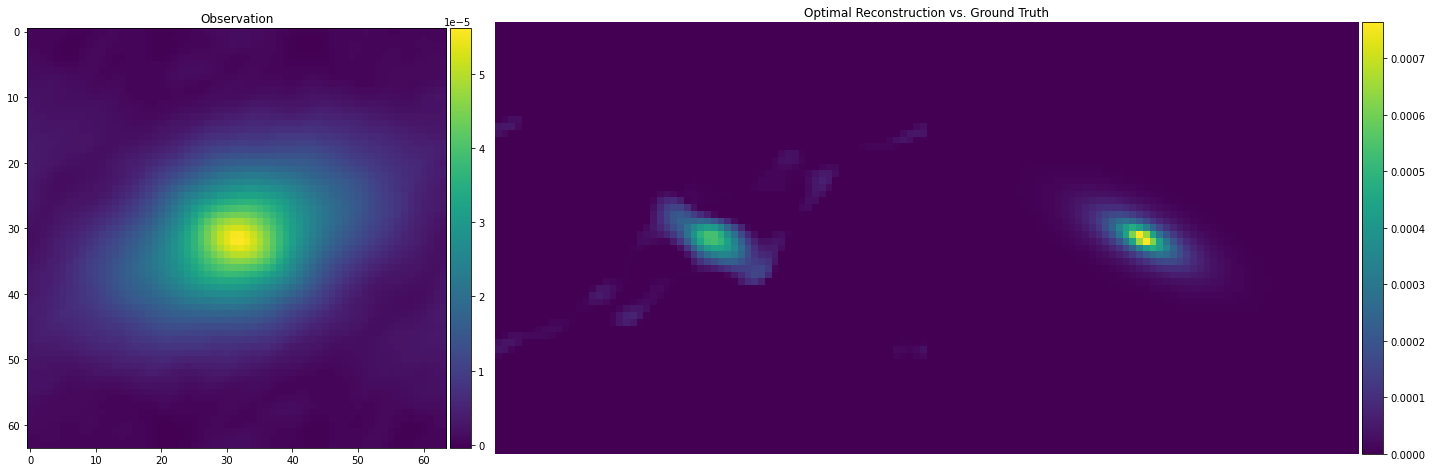

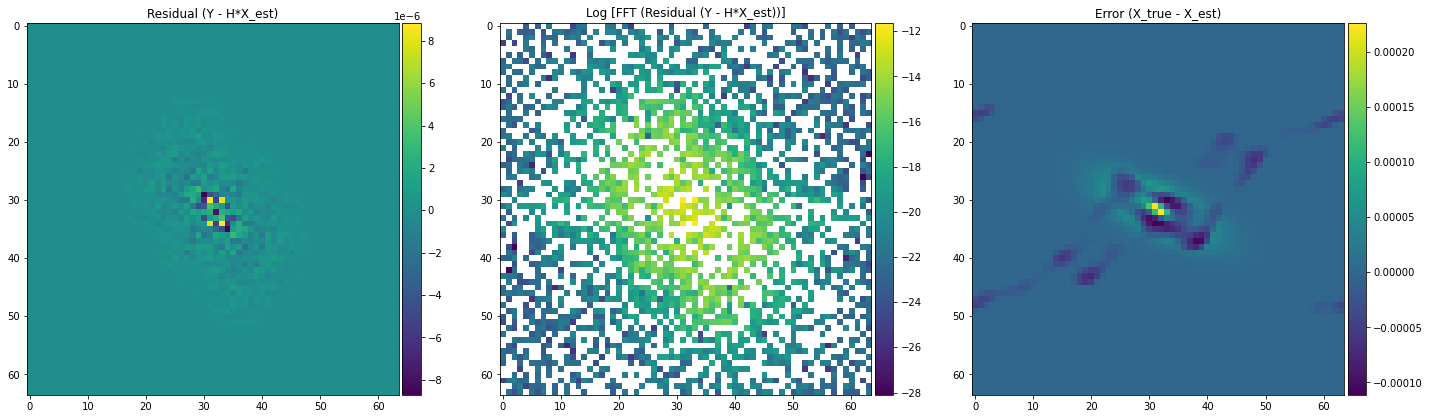

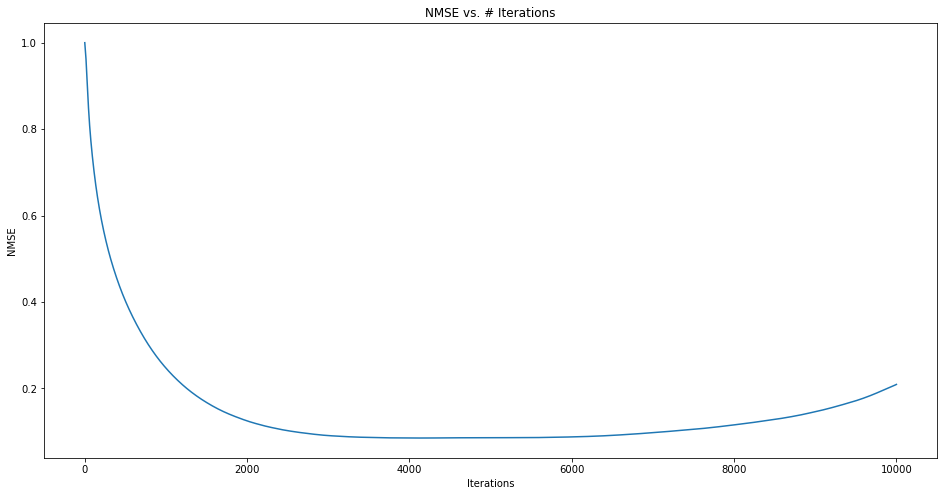


Minimum NMSE = 0.08537475764751434 (at [4174 4175 4176 4177] iterations)


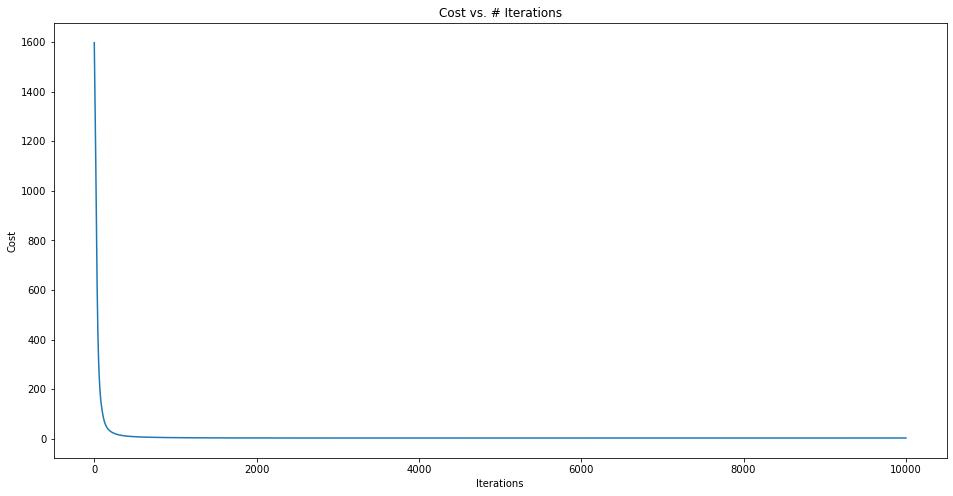


Minimum Cost = 2.8053462505340576 (at [4255] iterations)


In [14]:
rec_tf, nmse_tf = ADMM_tf(gal, final_gal, psf, n_iter, disp_step)

### Comparison - TF and NP

In [15]:
rec_im_diff = tf.keras.backend.get_value(rec_tf) - rec_np
nmse_diff = nmse_tf - nmse_np

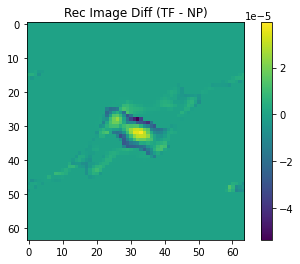

In [16]:
plt.imshow(rec_im_diff)
plt.colorbar()
plt.title('Rec Image Diff (TF - NP)')
plt.show()

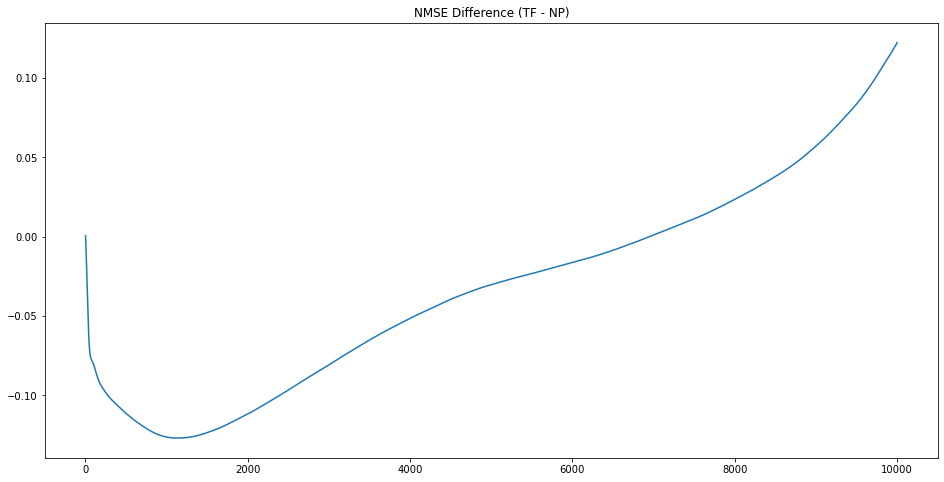

In [17]:
plt.figure(figsize=(16,8))
plt.plot(range(1,n_iter+1), nmse_diff)
plt.title('NMSE Difference (TF - NP)')
plt.show()